# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! pip install kaggle

In [ ]:
# ! mkdir ~/.kaggle


In [ ]:
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

In [ ]:
# ! unzip jigsaw-toxic-comment-classification-challenge.zip

In [ ]:
# ! unzip train.csv.zip

In [ ]:
# ! unzip test.csv.zip

In [ ]:
import numpy as np, pandas as pd

!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 5.4 MB 7.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.1 MB/s 
     |████████████████████████████████| 52 kB 745 kB/s 
     |████████████████████████████████| 462 kB 40.1 MB/s 
     |████████████████████████████████| 2.6 MB 34.4 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=bc112976af09a7b2ba9683c35b1b5d758f2526d27aa7acc80e5df1a5a76a6107
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
Successfully built chances
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Importing Data

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Toxic Comment Classifier/train.csv')    

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test=pd.read_csv('/content/drive/MyDrive/Toxic Comment Classifier/test.csv')

In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# Data Exploration

Checking for missing values

In [ ]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
test.isnull().any()


id              False
comment_text    False
dtype: bool

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):
  # lowering the text
  if is_lower:
    text=text.lower()
  #  identifying different patterns used for same words and replacing them with one word
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ") #removing next line characters
  text = re.sub(r'[^\w\s]',' ',text) # removing special char, ^ - negation, \w - alphabets, \s - white spaces
  text = re.sub('[0-9]',"",text) #removing numbers
  text = re.sub(" +", " ", text) # removing white spaces
  text = re.sub("([^\x00-\x7F])+"," ",text) #removing all non-ASCII characters
  return text 

Cleaning Training Data

In [ ]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [ ]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

## Lemmatization

In [ ]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [ ]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 
# getting the appropriate lemma with passing all the pos tags and selecting the last one.

Lemmatizing Training Data

In [ ]:
lemmatized_train_data = [] 
# tqdm_notebook displays the progress bar
for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
lemmatized_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

Lemmatizing Test Data

In [ ]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

## Stopwords Removal

In [ ]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS




In [ ]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [ ]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [ ]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

The criteria being that the words appear in the dataset very **frequently**, and second, they do **not** have a **significant contribution** towards the classification task

In [ ]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [ ]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [ ]:
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [ ]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

Counting the number of words in each of the 4 strings

In [ ]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [ ]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

Converting Dictionaries to Dataframe

In [ ]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [ ]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

Looking for common terms in all top 50 dataframes

In [ ]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [ ]:
print(common_potential_stopwords)

['mean', 'comment', 'help', 'work', 'thank', 'source', 'fact', 'edit', 'know', 'list', 'change', 'editor', 'block', 'page', 'delete', 'remove', 'add', 'good', 'fuck', 'talk', 'article', 'doe', 'image', 'user', 'section', 'find', 'try', 'people', 'use', 'like', 'need', 'want', 'read', 'write', 'information', 'new', 'think', 'point', 'way', 'thing', 'reference', 'link', 'look', 'wikipedia', 'question', 'don', 'deletion', 'time']


Retaining certain words and removing others from the above list

In [ ]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [ ]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [ ]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [ ]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
processed_train_data[152458]

'agree graemel intention revert nazi protect report revert rule notice board post report revert nazi graemel revert nazi unacceptable site admins feel unjustly revert hour period report revert noticeboard'

Removing Stopwords from Test Data

In [ ]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

# Model Building

In [ ]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [ ]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  148917


Padding

In [ ]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [ ]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

In [ ]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [ ]:
X_t = X_t[indices]
labels = y[indices]

### Splitting data into Training and Validation Set

In [ ]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [ ]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12212  1269  6717   387  6222  1133]
validation:  [3082  326 1732   91 1655  272]


### Importing Fast Text

fastText is another word embedding method that is an extension of the word2vec model. Instead of learning vectors for words directly, fastText represents each word as an n-gram of characters. So, for example, take the word, “artificial” with n=3, the fastText representation of this word is <ar, art, rti, tif, ifi, fic, ici, ial, al>, where the angular brackets indicate the beginning and end of the word.   

This helps capture the meaning of shorter words and allows the embeddings to understand suffixes and prefixes. Once the word has been represented using character n-grams, a skip-gram model is trained to learn the embeddings. This model is considered to be a bag of words model with a sliding window over a word because no internal structure of the word is taken into account. As long as the characters are within this window, the order of the n-grams doesn’t matter.  

fastText works well with rare words. So even if a word wasn’t seen during training, it can be broken down into n-grams to get its embeddings.

Word2vec and GloVe both fail to provide any vector representation for words that are not in the model dictionary. This is a huge advantage of this method.  

In [ ]:
embeddings_index_fasttext = {}
f = open('/content/drive/MyDrive/Toxic Comment Classifier/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [ ]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


### Creating Model

Talos is used for hyper parameter tuning. It works similarly to GridSearchCV, by testing all possible combinations of those parameters you have introduced, and chooses the best model, based on what parameter you have asked it to either optimize or reduce.

#### Talos Grid Search  for LSTM Model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

When running the code with Talos in the scan-command, all possible combinations are tested in one experiment. The best model is then saved and can be applied just like if you made a neural network using Keras.

In [ ]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[1],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[30, 1, 40, 0.1, 32, 'sigmoid', 1, 'adam', '03/26/22-153909',
        'relu', '03/26/22-154137', 148.06198573112488, 0],
       [30, 1, 50, 0.1, 32, 'sigmoid', 1, 'adam', '03/26/22-154137',
        'relu', '03/26/22-154435', 177.52344298362732, 1],
       [50, 1, 50, 0.2, 32, 'sigmoid', 1, 'adam', '03/26/22-162827',
        'relu', '03/26/22-163152', 205.10503506660461, 2],
       [50, 1, 40, 0.2, 32, 'sigmoid', 1, 'adam', '03/26/22-162558',
        'relu', '03/26/22-162826', 148.01395797729492, 3],
       [40, 1, 60, 0.2, 32, 'sigmoid', 1, 'adam', '03/26/22-162232',
        'relu', '03/26/22-162557', 204.97047805786133, 4],
       [40, 1, 50, 0.2, 32, 'sigmoid', 1, 'adam', '03/26/22-161932',
        'relu', '03/26/22-162232', 179.05318880081177, 5],
       [40, 1, 40, 0.2, 32, 'sigmoid', 1, 'adam', '03/26/22-161704',
        'relu', '03/26/22-161932', 147.46804094314575, 6],
       [30, 1, 60, 0.2, 32, 'sigmoid', 1, 'adam', '03/26/22-161339',
        'relu', '03/26/22-161704', 

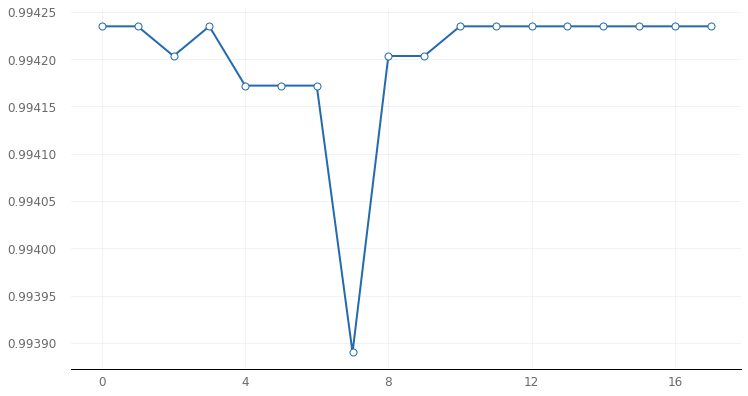

In [ ]:
analyze_object.plot_line('val_accuracy')

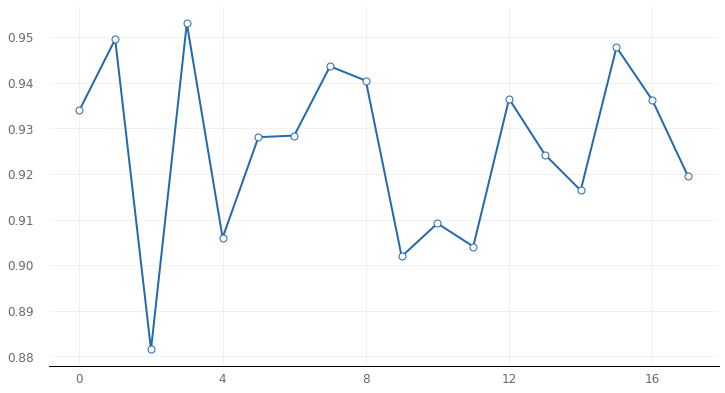

In [ ]:
analyze_object.plot_line('accuracy')

#### Talos Grid Search  for LSTM-CNN Model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

  x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)

  x = MaxPooling1D(params['pool_size'])(x)
  
  x = GlobalMaxPool1D()(x)
  
  x = BatchNormalization()(x)
  
  x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)

  x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [50,60],
    'output_1_count_dense': [40,50],
    'output_2_count_dense': [30,40],
    'filters' : [64],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [3],
    'epochs':[1],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

In [ ]:
scan_results.data[8:9]

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,activation,batch_size,...,epochs,filters,kernel_size,last_activation,loss,optimizer,output_1_count_dense,output_2_count_dense,output_count_lstm,pool_size
8,03/26/22-170557,03/26/22-170923,205.354313,1,0.077007,0.892697,0.053339,0.994235,relu,32,...,1,64,3,sigmoid,binary_crossentropy,adam,40,30,50,3


In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[1, 50, 30, 3, 0.1, 40, 32, 'sigmoid', 1, 3, 'adam', 64,
        '03/26/22-163837', 'relu', '03/26/22-164203', 205.45927000045776,
        0],
       [1, 50, 40, 3, 0.1, 40, 32, 'sigmoid', 1, 3, 'adam', 64,
        '03/26/22-164626', 'relu', '03/26/22-164952', 205.36640000343323,
        1],
       [1, 50, 30, 3, 0.2, 40, 32, 'sigmoid', 1, 3, 'adam', 64,
        '03/26/22-170557', 'relu', '03/26/22-170923', 205.3543131351471,
        2],
       [1, 60, 30, 3, 0.2, 40, 32, 'sigmoid', 1, 3, 'adam', 64,
        '03/26/22-170923', 'relu', '03/26/22-171249', 205.65624332427979,
        3],
       [1, 50, 40, 3, 0.2, 40, 32, 'sigmoid', 1, 3, 'adam', 64,
        '03/26/22-171250', 'relu', '03/26/22-171608', 197.5965712070465,
        4],
       [1, 50, 30, 3, 0.2, 50, 32, 'sigmoid', 1, 3, 'adam', 64,
        '03/26/22-171935', 'relu', '03/26/22-172300', 205.43783116340637,
        5],
       [1, 50, 40, 3, 0.2, 50, 32, 'sigmoid', 1, 3, 'adam', 64,
        '03/26/22-172614', 'relu', '03

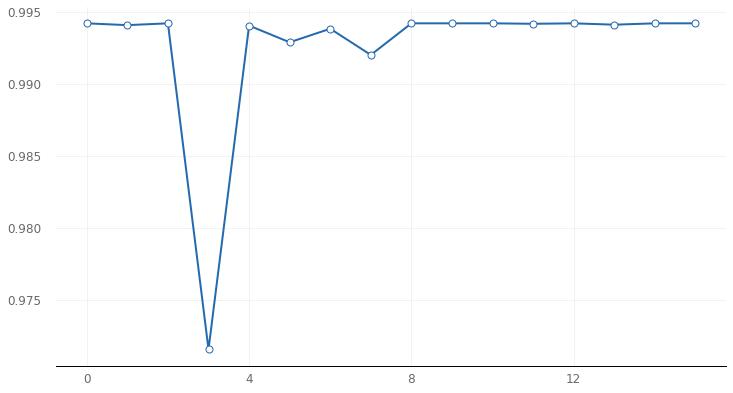

In [ ]:
analyze_object.plot_line('val_accuracy')

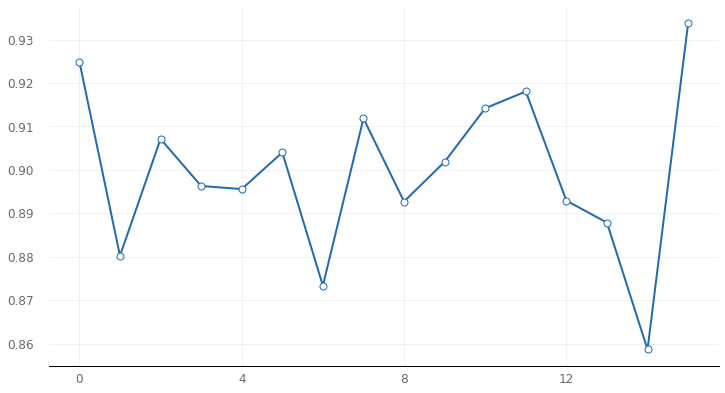

In [ ]:
analyze_object.plot_line('accuracy')

#### Training Model with Best Parameters

LSTM

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44675400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                             

In [ ]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 152s 37ms/step - loss: 0.0638 - accuracy: 0.9263 - val_loss: 0.0503 - val_accuracy: 0.9942
Epoch 2/2
3990/3990 [==============================] - 142s 36ms/step - loss: 0.0497 - accuracy: 0.9884 - val_loss: 0.0467 - val_accuracy: 0.9940


LSTM-CNN

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44675400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 50)           70200     
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 64)           0         
 )                                                               
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

In [ ]:
model_info_2=model_2.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 188s 46ms/step - loss: 0.0758 - accuracy: 0.8872 - val_loss: 0.0566 - val_accuracy: 0.9942
Epoch 2/2
3990/3990 [==============================] - 181s 45ms/step - loss: 0.0552 - accuracy: 0.9842 - val_loss: 0.0511 - val_accuracy: 0.9941


## Plotting Graphs

### LSTM

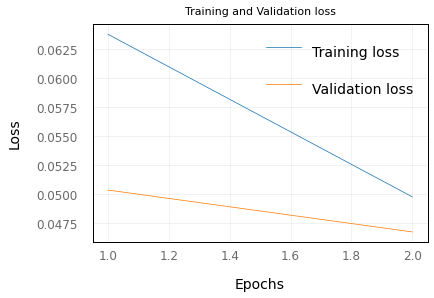

In [ ]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

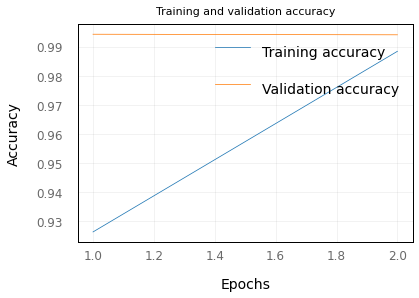

In [ ]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

### LSTM-CNN

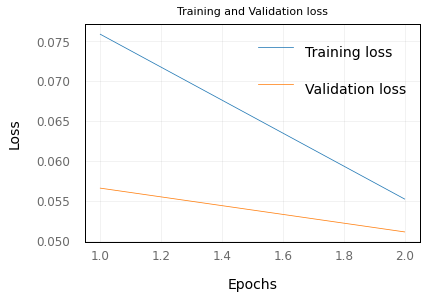

In [ ]:
loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

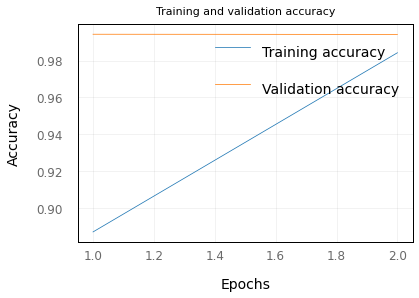

In [ ]:
accuracy = model_info_2.history['accuracy']
val_accuracy = model_info_2.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [ ]:
model_1.save(filepath="/content/drive/MyDrive/Toxic Comment Classifier/model1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Toxic Comment Classifier/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Toxic Comment Classifier/model1/assets


In [ ]:
model_2.save(filepath="/content/drive/MyDrive/Toxic Comment Classifier/model2")

NameError: ignored

# Loading Saved Model

In [ ]:
loaded_model_1 = keras.models.load_model(filepath="/content/drive/MyDrive/Toxic Comment Classifier/model1")

In [ ]:
loaded_model_2 = keras.models.load_model(filepath="/content/drive/MyDrive/Toxic Comment Classifier/model2")

# Generating the Output

### LSTM

In [ ]:
test_values_1 = loaded_model_1.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 1348s 9ms/step


In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Toxic Comment Classifier/sample_submission.csv')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv('/content/drive/MyDrive/Toxic Comment Classifier/combined', index=False)

### LSTM-CNN

In [ ]:
test_values_2 = loaded_model_2.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 1413s 9ms/step


In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Toxic Comment Classifier/sample_submission.csv')
test_values_2=pd.DataFrame(test_values_2,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_2],axis=1)
combined_submission.to_csv('/content/drive/MyDrive/Toxic Comment Classifier/combined_2', index=False)

# Testing the Created Model

In [ ]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = loaded_model_1.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [ ]:
toxicity_level('go jump off a bridge jerk')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         66%
Severe Toxic:  1%
Obscene:       21%
Threat:        1%
Insult:        34%
Identity Hate: 0%



In [ ]:
toxicity_level('i will kill you')

Toxicity levels for 'i will kill you':
Toxic:         38%
Severe Toxic:  0%
Obscene:       4%
Threat:        3%
Insult:        7%
Identity Hate: 1%



In [ ]:
toxicity_level('have a nice day')

Toxicity levels for 'have a nice day':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('fuck ofF!!')

Toxicity levels for 'fuck ofF!!':
Toxic:         99%
Severe Toxic:  25%
Obscene:       97%
Threat:        1%
Insult:        67%
Identity Hate: 0%



In [ ]:
toxicity_level('Hello, How are you?')

Toxicity levels for 'Hello, How are you?':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('get the fuck away from me @sshole!!')

Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         96%
Severe Toxic:  11%
Obscene:       92%
Threat:        1%
Insult:        53%
Identity Hate: 1%

